In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from primesieve import *


In [118]:
B = 1 #amount of buckets
SHINGLES = 2 #n for the n-gram
PERMUTATIONS = 2 # how many permutations / hashes you want
TRESHOLD = 0.7 #similarity threshold

print(1 - np.power((1 - np.power(TRESHOLD, PERMUTATIONS / B)), B)) #probability that we find a canditate pair
print(PERMUTATIONS/B) #amount of rows each bucket will have

0.49
2.0


In [119]:
df = pd.read_csv("news_articles_small.csv")
# df = pd.read_csv("news_articles_large.csv")

print(df.head())

   News_ID                                            article
0        0  The Supreme Court in Johnnesberg on Friday pos...
1        1  The IG Metall union has decided not to spread ...
2        2  Malaysia said Friday it had no plans to overre...
3        3  South Korea is redoubling its efforts behind K...
4        4  The Philippine subsidiary of US telecommunicat...


# Jaccard similarity

In [120]:
shingles = SHINGLES
shingles_dict = dict() #dictionary for the fingerprint of every shsingle

In [121]:
# convert articles into sets of shingles.
def apply_shingles(input):
    s = set()
    l = input.split(' ')
    for ind in range((len(l) - shingles + 1)):
        word = ' '.join(l[ind:ind+shingles])
        #if a shingle is not in the dict, add it with a new fingerprint which is the length
        #of the dict at that point
        if word not in shingles_dict:
            shingles_dict[word] = len(shingles_dict)
        s.add(shingles_dict[word])
    return s
        
df["shingles"] = df["article"].apply(apply_shingles)
print(df.head())

   News_ID                                            article  \
0        0  The Supreme Court in Johnnesberg on Friday pos...   
1        1  The IG Metall union has decided not to spread ...   
2        2  Malaysia said Friday it had no plans to overre...   
3        3  South Korea is redoubling its efforts behind K...   
4        4  The Philippine subsidiary of US telecommunicat...   

                                            shingles  
0  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
1  {512, 513, 514, 515, 516, 517, 518, 519, 520, ...  
2  {526, 527, 528, 529, 530, 531, 532, 533, 534, ...  
3  {1, 5, 554, 555, 556, 557, 558, 45, 560, 561, ...  
4  {1024, 1025, 1026, 1027, 1028, 1029, 1030, 103...  


In [122]:
# function to calculate jaccard similarity
def similarity(a, b):
    return (len(a & b) / len(a | b))

In [123]:
%%time
# calculate similarity between all documents, plot in histogram
similarities = list()
no_repeating = set()
for ind_i, i in enumerate(df["shingles"]):
    for ind_j, j in enumerate(df["shingles"]):
        #to make sure that (a,b) and (b,a) are not both given
        if (ind_j, ind_i) in no_repeating:
            pass
        else:
            no_repeating.add((ind_i, ind_j))
            if ind_i != ind_j:
                similarities.append(similarity(i, j))

hist = np.histogram(similarities, bins=10, range=(0, 1))

CPU times: user 7.68 s, sys: 0 ns, total: 7.68 s
Wall time: 7.68 s


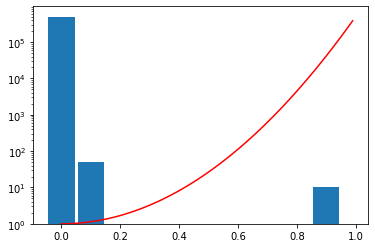

CPU times: user 437 ms, sys: 0 ns, total: 437 ms
Wall time: 432 ms


In [124]:
%%time
# draw histogram
fig, ax = plt.subplots()
ax.bar(hist[1][:-1], hist[0], width=0.09)
ax.set_yscale("log")
#Draw a red line for the probability and reverse the logarithmic scale together with
#scaling to the max value of the histogram
x = [i/100 for i in range(0, 100)]
ax.plot(x, np.power(10, (1 - np.power((1 - np.power(x, PERMUTATIONS / B)), B)) * np.log10(hist[0][0])), "r")
plt.ylim(bottom=1)
plt.show()

In [125]:
# print histogram distribution to see actual values
print(hist)

(array([499439,     51,      0,      0,      0,      0,      0,      0,
            0,     10]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


# Create minhash

In [95]:
# set up parameters
num_perm = PERMUTATIONS
all_shingles = np.array(list(shingles_dict.values()))

In [96]:
%%time
#Function to generate a certain number of permutations of all shingles
def make_permutations():
    permutations = np.zeros(shape=(num_perm, len(all_shingles)), dtype=int)
    for i in range(num_perm):
        cont = True
        #Use of a while loop to counter the small possibility of having the same random permutation
        while cont:
            cont = False
            perm = np.random.permutation(all_shingles)
            for j in range(i):
                if (permutations[j] == perm).all():
                    cont = True
        permutations[i] = perm
    return permutations

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 13.8 µs


In [97]:
%%time
#Function to create a sign matrix based on the minimum index of the permutations
def make_sign_matrix_permu(permutations=make_permutations()):
    sign_matrix = np.zeros(shape=(num_perm, len(df.shingles)), dtype=int)
    for doc_index, document in enumerate(df.shingles):
        for perm_index, perm in enumerate(permutations):
            for shingle_index, shingle in enumerate(perm):
                #break after the first found shingle since this is the minimum
                if shingle in document:
                    sign_matrix[perm_index, doc_index] = shingle_index
                    break
    return sign_matrix

CPU times: user 2.63 ms, sys: 12 ms, total: 14.6 ms
Wall time: 13.4 ms


In [98]:
%%time
#Class for a hash function so it can be used in an array
class Hash:

    def __init__(self, a, b, p, len_shingles):
        '''
        :param a: random between 1 and p-1
        :param b: random between 0 and p-1
        :param p: prime number larger than len_shingles
        :param len_shingles:
        '''
        self.a = a
        self.b = b
        self.p = p
        self.len_shingles = len_shingles

    #universal hash
    def __call__(self, *args, **kwargs):
        return ((self.a * args[0] + self.b) % self.p) % self.len_shingles

#Function to generate a certain number of hashes with each a random a and b
def make_hashes():
    p = n_primes(1,len(all_shingles))[0]
    hashes = []
    len_shingles = len(all_shingles)
    for i in range(num_perm):
        a = np.random.randint(1, p-1)
        b = np.random.randint(0, p-1)
        hashes.append(Hash(a,b,p,len_shingles))
    return hashes

CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 29.6 µs


In [99]:
%%time
#Function to create a sign matrix based on the hash functions
def make_sign_matrix_hash(hashes=make_hashes()):
    sign_matrix = np.zeros(shape=(num_perm, len(df.shingles)), dtype=int)
    for doc_index, document in enumerate(df.shingles):
        #For every hash function hash each shingle and compare for the minimum
        for hash_index, hash in enumerate(hashes):
            min = float('inf')
            for shingle in document:
                tmp = hash(shingle)
                if tmp < min:
                    min = tmp
            sign_matrix[hash_index, doc_index] = min
    return sign_matrix

CPU times: user 120 µs, sys: 2 µs, total: 122 µs
Wall time: 127 µs


In [100]:
#creation of a sign matrix with a single option
sign_matrix = make_sign_matrix_hash()
#sign_matrix = make_sign_matrix_permu()

# Locality-Sensitive Hashing

In [101]:
bands = B

In [102]:
#split of the sign matrix in bands
table = np.split(sign_matrix, bands)
htable = [dict()] * bands

candidate_pairs = set()

In [103]:
print(table[0][0][0:10])
print(table[0][1][0:10])

[2489  513   19   19   20  513  513   21 2739   20]
[572 429 143   0 672 286 386 100 572 572]


In [104]:
%%time
#creation of canditate pairs by hashing with a dictionary
for band_index, band in enumerate(table):
    #Transpose since using rows for each document is easier than using columns
    for row_index, row in enumerate(band.T):
        #If it already occurs in the table add the candidate pairs or else create a new set
        if row.tostring() in htable[band_index]:
            for candidate in htable[band_index][row.tostring()]:
                candidate_pairs.add((row_index, candidate))
            htable[band_index][row.tostring()].add(row_index)
        else:
            htable[band_index][row.tostring()] = {row_index}

CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 1.86 ms


In [105]:
print(len(candidate_pairs))

1630


In [106]:
#for every pair calculate the effective similarity
for pair in candidate_pairs:
    print(similarity(df.shingles[pair[0]], df.shingles[pair[1]]))
    print("{", df["article"][pair[0]][:50], "}; {" , df["article"][pair[1]][:50], "}")
    print()

0.01680672268907563
{ The Credit Lyonnais state-owned bank on Tuesday ap }; { Football's law-makers revealed here on Saturday th }

0.013539651837524178
{ Portugal's foreign ministry said Wednesday that of }; { It would be a mistake for Washington to lift a ban }

0.01443298969072165
{ Share prices opened strongly higher on the Tokyo S }; { Militant groups here on Monday called on the Singa }

0.014285714285714285
{ Japan's trade surplus grew 5.3 percent from a year }; { China on Monday issued a new warning on British ho }

0.00819672131147541
{ An Israeli gunboat on Tuesday opened fire at two f }; { Militant groups here on Monday called on the Singa }

0.010940919037199124
{ Thousands of ecstatic Spaniards lined the elegant  }; { Buffeted by 30-mph winds and held up by slow play, }

0.01016260162601626
{ In Gaza City, neighbours of the two suspects said  }; { Some 13,000 Bosnians entitled to pensions from Ger }

0.012526096033402923
{ In Gaza City, neighbours of the two suspects said 

{ Some 13,000 Bosnians entitled to pensions from Ger }; { Existing data suggests there is unlikely to be sig }

0.016913319238900635
{ Hungary's cabinet devalued the forint by nine perc }; { Malawi's President Bakili Muluzi has cancelled his }

0.007619047619047619
{ An Israeli gunboat on Tuesday opened fire at two f }; { The Milan stock market nosedived on Friday due to  }

0.01059322033898305
{ The Credit Lyonnais state-owned bank on Tuesday ap }; { Existing data suggests there is unlikely to be sig }

0.014767932489451477
{ At least six people died and several others were i }; { Leading European stock markets all lost ground on  }

0.01059322033898305
{ Malaysian stock prices ended lower Monday amid con }; { Michael Jordan's increasingly likely return to bas }

0.0078125
{ Guinness, the beers and spirits group, has won new }; { Cheaper imports and free-market reforms are causin }

0.010706638115631691
{ US Secretary of State Warren Christopher on Wednes }; { The Mexican peso slumped

{ Guinness, the beers and spirits group, has won new }; { The Mexican peso slumped to a new record low of 7. }

0.01006036217303823
{ Jordan's appeal court Thursday rejected 11 death p }; { Industrialized countries and international institu }

0.019455252918287938
{ An unnamed "intermediary" linked to a group involv }; { Share prices opened marginally lower on the Tokyo  }

0.010101010101010102
{ Some 13,000 Bosnians entitled to pensions from Ger }; { At least six people died and several others were i }

0.012096774193548387
{ US Secretary of State Warren Christopher on Wednes }; { Buffeted by 30-mph winds and held up by slow play, }

0.018711018711018712
{ Congress and political leaders rallied behind Pres }; { US Secretary of State Warren Christopher held fres }

0.01171875
{ A 15-month scandal that has shocked Thais and, man }; { Germany's Steffi Graf moved within just one point  }

0.009689922480620155
{ Bosnian Serb leader Radovan Karadzic met internati }; { Ethnic clashes in nort

0.008350730688935281
{ Malaysian stock prices ended lower Monday amid con }; { Socialist Party presidential candidate Lionel Josp }

0.00980392156862745
{ Some 13,000 Bosnians entitled to pensions from Ger }; { South Korea accused North Korea Friday of staging  }

0.00998003992015968
{ A delegation representing nine African countries e }; { Ethnic clashes in northern Ghana have claimed 85 l }

0.008064516129032258
{ The loss of a 3.5 million dollar Israeli satellite }; { An international conference on controlling vital w }

0.012552301255230125
{ Malaysian stock prices ended lower Monday amid con }; { Militant groups here on Monday called on the Singa }

0.012269938650306749
{ Vietnamese actress Kieu Chinh and former hostage T }; { China's Lu Chen won the women's figure skating wor }

0.010183299389002037
{ Germany's Steffi Graf moved within just one point  }; { Vietnamese actress Kieu Chinh and former hostage T }

0.011363636363636364
{ Malaysian stock prices ended lower Monday amid c